In [60]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
plt.style.use('ggplot')

import seaborn as sns
import numpy as np

from sklearn import set_config ## SE AGREGA ESTO PARA QUE EL DIAGRAMA DEL PIPELINE APAREZCA INTERACTIVO
set_config(display='diagram') ## SE AGREGA ESTO PARA QUE EL DIAGRAMA DEL PIPELINE APAREZCA INTERACTIVO

from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from scipy.stats import chi2_contingency
from sklearn.metrics import roc_auc_score, cohen_kappa_score, accuracy_score, confusion_matrix
from  sklearn.base import clone ## Copiar un pipeline

import warnings
warnings.filterwarnings("ignore")


In [ ]:
! python --version

In [2]:
train = pd.read_csv('Train.csv')

In [ ]:
train.head(2)

In [ ]:
train.info()

In [4]:
## Realizamos una copia del dataset original en caso de volver a ocupar esta versión sin cambios.
train_original = train.copy()

In [3]:
## Se verifica si hay datos duplicados
train.loc[train.duplicated()]

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation


In [5]:
## Se elimina la variable ID, no es relevante para el análisis
train.drop('ID', axis = 1, inplace = True)

## Limpieza y EDA

### a. Control de calidad de los datos.
En esta sección se realiza una revisión del tipo de variables y el número de datos faltantes en el data set de entrenamiento.

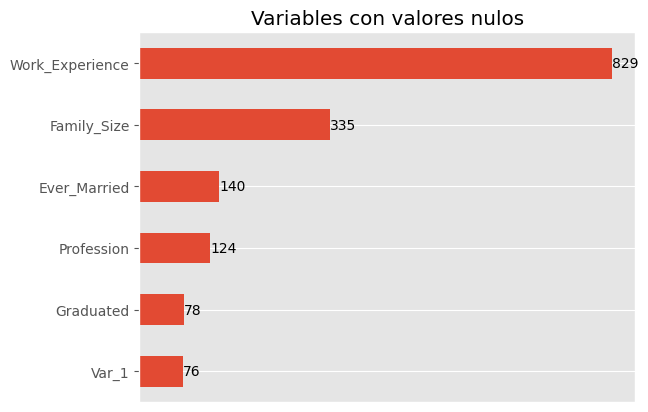

In [6]:
ax = train.isnull().sum()[train.isnull().sum()>0].sort_values().plot(kind = 'barh')
ax.bar_label(ax.containers[0])
ax.set_title('Variables con valores nulos')
ax.get_xaxis().set_visible(False)
plt.show()

In [7]:
train.isnull().sum(axis = 1).value_counts()

0    6665
1    1244
2     140
3      18
4       1
Name: count, dtype: int64

* En el control de calidad de los datos, se encuentra que el dataset consta de 8.608 observaciones y 11 variables, las cuales todas tienen el tipo de variable esperado. 

* Con respecto a los datos faltantes, la variable ***Work_Experience*** es la que mayor cantidad de nulos tiene (829), seguido de ***Family_Size*** (335).

* En cuanto a el número de nulos por observación se encuentra que, existen 6.665 registros completos, 1.244 registros con un dato faltante en 1 columna, 140 registros con datos faltantes en 2 columnas y 19 registros con al menos 3 columnas sin dato.

In [8]:
## SE DEFINE FUNCIÓN PARA SEPARAR LAS VARIABLES CATEGÓRICAS, NUMÉRICAS Y LA DEPENDIENTE
def SepararNumCate(df : pd.DataFrame):
    '''Returns a triplet with column names (numerical, categorical, target)
    '''
    numerical = df.select_dtypes(include = 'number').columns.to_list()
    categorical = df.select_dtypes(exclude = 'number').columns.to_list()
    categorical.remove('Segmentation') ## REMOVES THE TARGET VARIABLE
    target = ['Segmentation']
    return numerical, categorical, target


num_idx, categ_idx, target_idx = SepararNumCate(train)

In [9]:
## Identificar los valores únicos de las variables categóricas
for i in train[categ_idx + target_idx].columns:
    print(f'Categorías de la variable "{i}" ',train[i].unique(),'\n')

Categorías de la variable "Gender"  ['Male' 'Female'] 

Categorías de la variable "Ever_Married"  ['No' 'Yes' nan] 

Categorías de la variable "Graduated"  ['No' 'Yes' nan] 

Categorías de la variable "Profession"  ['Healthcare' 'Engineer' 'Lawyer' 'Entertainment' 'Artist' 'Executive'
 'Doctor' 'Homemaker' 'Marketing' nan] 

Categorías de la variable "Spending_Score"  ['Low' 'Average' 'High'] 

Categorías de la variable "Var_1"  ['Cat_4' 'Cat_6' 'Cat_7' 'Cat_3' 'Cat_1' 'Cat_2' nan 'Cat_5'] 

Categorías de la variable "Segmentation"  ['D' 'A' 'B' 'C'] 



Para elegir qué se va a realizar con respecto a los valores faltantes se proponen 3 estrategias que se pondrán a prueba:

> - 1. Un data set de entrenamiento eliminando todos las observaciones que tengan al menos 1 dato faltante, lo que representa quedarse con un 75% del data set de entrenamiento inicial.

> - 2. Un data set de entrenamiento donde se eliminan las observaciones que tienen 2 o más datos nulos y a la observación que quede con dato un nulo se le asigna el valor del dato, mediante algún método de imputación.

> - 3. Un data set donde no se elimina ningún registro, se asigna el valor de los datos por algún método de imputación.


**Definimos los pipelines y la función por la cual va a pasar cada uno de los dataset de las anteriores estrategias**

In [39]:
### Pipelines

numerical_pipeline = Pipeline( steps = [
    ('scaler',StandardScaler())
])

categ_pipeline = Pipeline( steps = [
    ('encoder',OneHotEncoder(handle_unknown = 'ignore'))
])

## ColumnTransformer
columnsTransf = ColumnTransformer(transformers = [
                    ('numerical_pl',numerical_pipeline,num_idx),
                    ('categorical_pl',categ_pipeline,categ_idx)
                            ],
                    remainder = 'drop'
                                )

rf_model = RandomForestClassifier(random_state = 123)
lr_model = LogisticRegression()
nb_model = GaussianNB()
kn_clf_model = KNeighborsClassifier()


### Diccionario que contiene todos los pipelines
pl_dict = { 'RandomForest' : Pipeline( steps = [
                                    ('col_transf',columnsTransf),
                                    ('model',rf_model)
                                        ]),
            'LogisticRegression' : Pipeline( steps = [
                                    ('col_transf',columnsTransf),
                                    ('model',lr_model)
                                        ]),
            'NaiveBayes' : Pipeline( steps = [
                                    ('col_transf',columnsTransf),
                                    ('model',nb_model)
                                         ]),
            'KNeighborsClassifier' : Pipeline( steps = [
                                    ('col_transf',columnsTransf),
                                    ('model',kn_clf_model)
                                         ])

           }

## Crear el pipeline para la imputación
num_imputer = Pipeline(steps = [
        ('num_imputer',SimpleImputer(strategy = 'median')),
])

cat_imputer = Pipeline(steps = [
    ('cat_imputer',SimpleImputer(strategy = 'most_frequent'))
])

columnImputer = ColumnTransformer(transformers = [
    ('Numerical',num_imputer,num_idx),
    ('Categorical', cat_imputer, categ_idx)
                                ], 
            remainder = 'passthrough' ## En este caso no se utiliza el passthrough porque necesitamos nuestra variable objetivo, ya que este pipeline es sólo para transformar columna
)

imputer_pipe = Pipeline(steps=[
    ('columns_transf',columnImputer)
])

def ImputersTest(df : pd.DataFrame,  numerical_columns : list, 
                 categorical_columns : list, target : str, model : str): 
    if model in pl_dict.keys():
        pipe = clone(pl_dict.get(model))
        print(f"Accuracy with CV : {cross_val_score(pipe,df[numerical_columns + categorical_columns], df[target], cv = 5, scoring = 'accuracy').mean()}")
        return None
    else:
        print(f'{model} no es un modelo implementado, las opciones son {list(pl_dict.keys())}')

### Estrategia 1

No hacer ningún tratamiento de imputación, se eliminan las filas que contengan NA's.

In [11]:
train1 = train.dropna( axis = 0).copy()

In [12]:
ImputersTest(train1 ,num_idx, categ_idx, target_idx, 'RandomForest')

Accuracy with CV : 0.48012003000750186


### Estrategia 2

In [13]:
## Se eliminan las filas que tienen datos faltantes en 2 o más de sus columnas
train2 = train.drop(train.loc[train.isna().sum(axis = 1) >= 2].index).copy()

In [14]:
train2_imp = pd.DataFrame(clone(imputer_pipe).fit_transform(train2), columns = num_idx + categ_idx + target_idx)

In [15]:
ImputersTest(train2_imp,num_idx,categ_idx,target_idx,'RandomForest')

Accuracy with CV : 0.48173082535897604


### Estrategia 3

In [16]:
train3 = train.copy()

In [17]:
train3_imp = pd.DataFrame(clone(imputer_pipe).fit_transform(train3), columns = num_idx + categ_idx + target_idx)

In [18]:
ImputersTest(train3_imp,num_idx,categ_idx,target_idx,'RandomForest')

Accuracy with CV : 0.476822763620552


De las 3 estrategias propuestas y evaluadas, todas presentaron un accuracy similar, No obstante si se eliminan todos los datos faltantes (estrategia 1) se perdería alrededor del 17% de las observaciones, mientras que si se eliminan sólo aquellos registros cuyas observaciones tengan nulos en 2 o más variables se perdería alrededor del 2% del dataset original. Por lo cual, se realizará el resto del ejercicio con el dataset derivado de la estrategia 2.

In [28]:
## Definimos el dataset imputado para seguir trabajando el resto del ejercicio
del train ## se elimina el df que tenía este nombre

train = train2_imp.copy().astype(train1.dtypes.to_dict()) ## Se le asignan el tipo de variables de uno de los datasets ya que con la imputación todas las variables quedan como tipo object.


### b. Visualización de la información

* **Balanceo de la variable dependiente**

  Cada una de las categorías de la variable Segmentation contiene alrededor del 25% de las observaciones, por lo que al dataset no hay que realizarle procesos de balanceo.

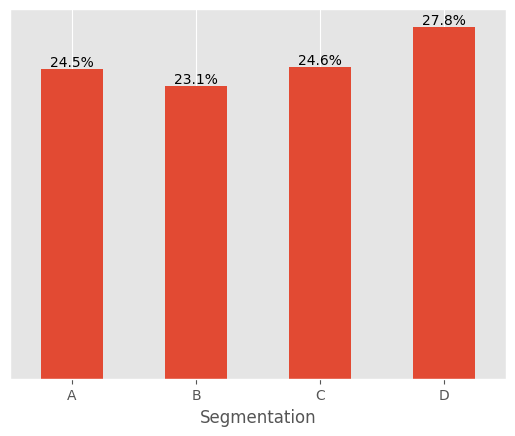

In [30]:
ax = train.Segmentation.value_counts(normalize = True).sort_index().plot( kind = 'bar')
ax.get_yaxis().set_visible(False)
labels = (train.Segmentation.value_counts(normalize = True).sort_index()*100).round(1).astype('str') + '%' ## ETIQUETA DE LAS BARRAS QUE SE MUESTRE EN %
ax.tick_params(axis='x', rotation = 0)  ## ROTAR LAS ETIQUETAS DEL EJE X
for container in ax.containers:
    ax.bar_label(container, labels = labels)
plt.show()

DESCRIPCIÓN VARIABLES NUMÉRICAS VS VARIABLE DEPENDIENTE
* **Segmentación vs Edad:**

    En los siguientes gráficos se observa que el grupo D, tiene en promedio una edad menor que el resto de grupos, siendo esta alrededor de los 32 años. Los 3 grupos restantes tienen una edad promedio muy cercana a los 50 años.

* **Segmentación vs Experiencia laboral**

    En la gráfica siguiente se observa que el promedio de experiencia laboral para todas las categorías de Segmentation se encuentra entre los 2 y 3 años, también es posible identificar que el grupo D es el que más experiencia tiene puesto que un 75% de los individuos tienen una experiencia laboral de 6 años o menos, y el grupo C es el que menos experiencia tiene ya que el 75% de los individuos tienen una experiencia de 3 años o menos.


* **Segmentation vs Family Size**

  El tamaño del núcleo familiar tiene una distribución similar para los segmentos B, C y D, donde el 75% de los individuos cada uno de estos grupos tiene un núcleo familiar conformado por 4 o menos personas, por otra parte el núcleo familiar del Segmento A es más reducido donde el 75% de los individuos tienen un núcleo familiar de 3 o menos personas.

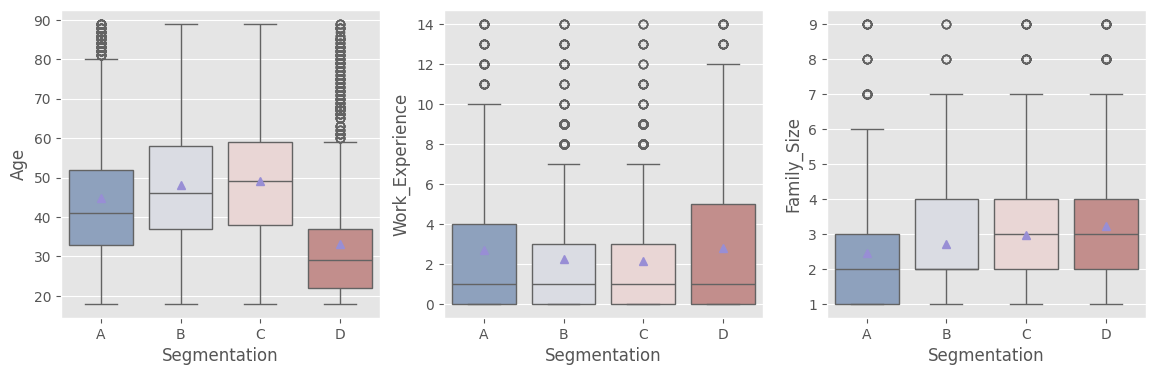

In [34]:
fig, (ax1 ,ax2, ax3) = plt.subplots(1,3, figsize = (14,4))
sns.boxplot(data = train, x = 'Segmentation', y = 'Age',order = train.Segmentation.sort_values().unique(), ax = ax1, showmeans = True, palette = 'vlag')
sns.boxplot(data = train, x = 'Segmentation', y = 'Work_Experience', order = train.Segmentation.sort_values().unique(), ax = ax2, showmeans = True,palette="vlag")
sns.boxplot(data = train, x = 'Segmentation', y = 'Family_Size', order = train.Segmentation.sort_values().unique(), ax = ax3, showmeans = True, palette="vlag")

#//TODO ...poner la media como texto en cada uno de los boxplots
# Calcular la media por categoría
# means = train.groupby('Segmentation')[['Age', 'Work_Experience', 'Family_Size']].mean().values

# Agregar líneas para la media y la mediana
#for i in range(len(train.Segmentation.sort_values().unique())):
 #   plt.text(i, means[i], f'{means[i]:.2f}', ha='center', va='bottom', color='blue', fontsize=8)

plt.show()


* **Género vs Segmentación**

   Con respecto a la distribución del género por Segmentación, la participación en todos los grupos de ambos géneros es similar a excepción del grupo D, donde la participación de los hombres es casi del 60%.

* **Ever_Married vs Segmentación**
  
  La variable categórica que toma en cuenta si el individuo ha estado casado alguna vez presenta la siguiente distribución: en los grupos A, B y C la mayoría de personas han estado casados, teniendo una mayor participación elos grupos A y B alcanzando casi el 80%. El grupo D por el contrario más del 70% de los individuos no han estado casados, este grupo como se vió en anteriores gráficas es el grupo con menor promedio de edad.
  
* **Graduated vs Segmentation**

    La variable binaria que captura si el individuo se graduó sigue el comportamiento siguiente diferenciándola por la Segmentación: En los grupos A, B y C más del 60% son graduados, caso contrario en el grupo D donde poco más del 60% de los individuos no son graduados.

* **Spending_Score vs Segmentation**
    La variable categórica que captura si el puntaje de consumo es bajo, medio o alto presenta la siguiente distribución: Los grupos A, B y D predominan las personas que tienen un consumo bajo, siendo en el grupo D casi la totalidad de personas que tienen un consumo bajo, por su parte en el grupo C  predomina el consumo promedio con un poco más del 40%.

* **Profession vs Segmentation**
  
  Con respecto a la profesión del cliente:
    - El grupo A la mayor participación la tienen los artistas con casi el 30% de los individuos seguido de los profesionales del entretenimiento.
    - El grupo B la mayor participación la tienen los artistas con más del 40% de los individuos seguido por los profesionales del entretenimiento.
    - El grupo C la mayor participación la tienen los artistas con más del 50% de los individuos seguido por los ejecutivos.
    - El grupo D la mayor participación la tienen los profesionales de la salud con más del 40% seguido por los doctores y profesionales del entretenamiento.
     
* **Var_1 vs Segmentation**

  Con respecto a una categoría anónima que se le asigna a cada cliente la categoría 6 tiene la mayor participación en todos los segmentos con más del 60% de todos los individuos para los grupos A, B y C, y más del 50% en el grupo D

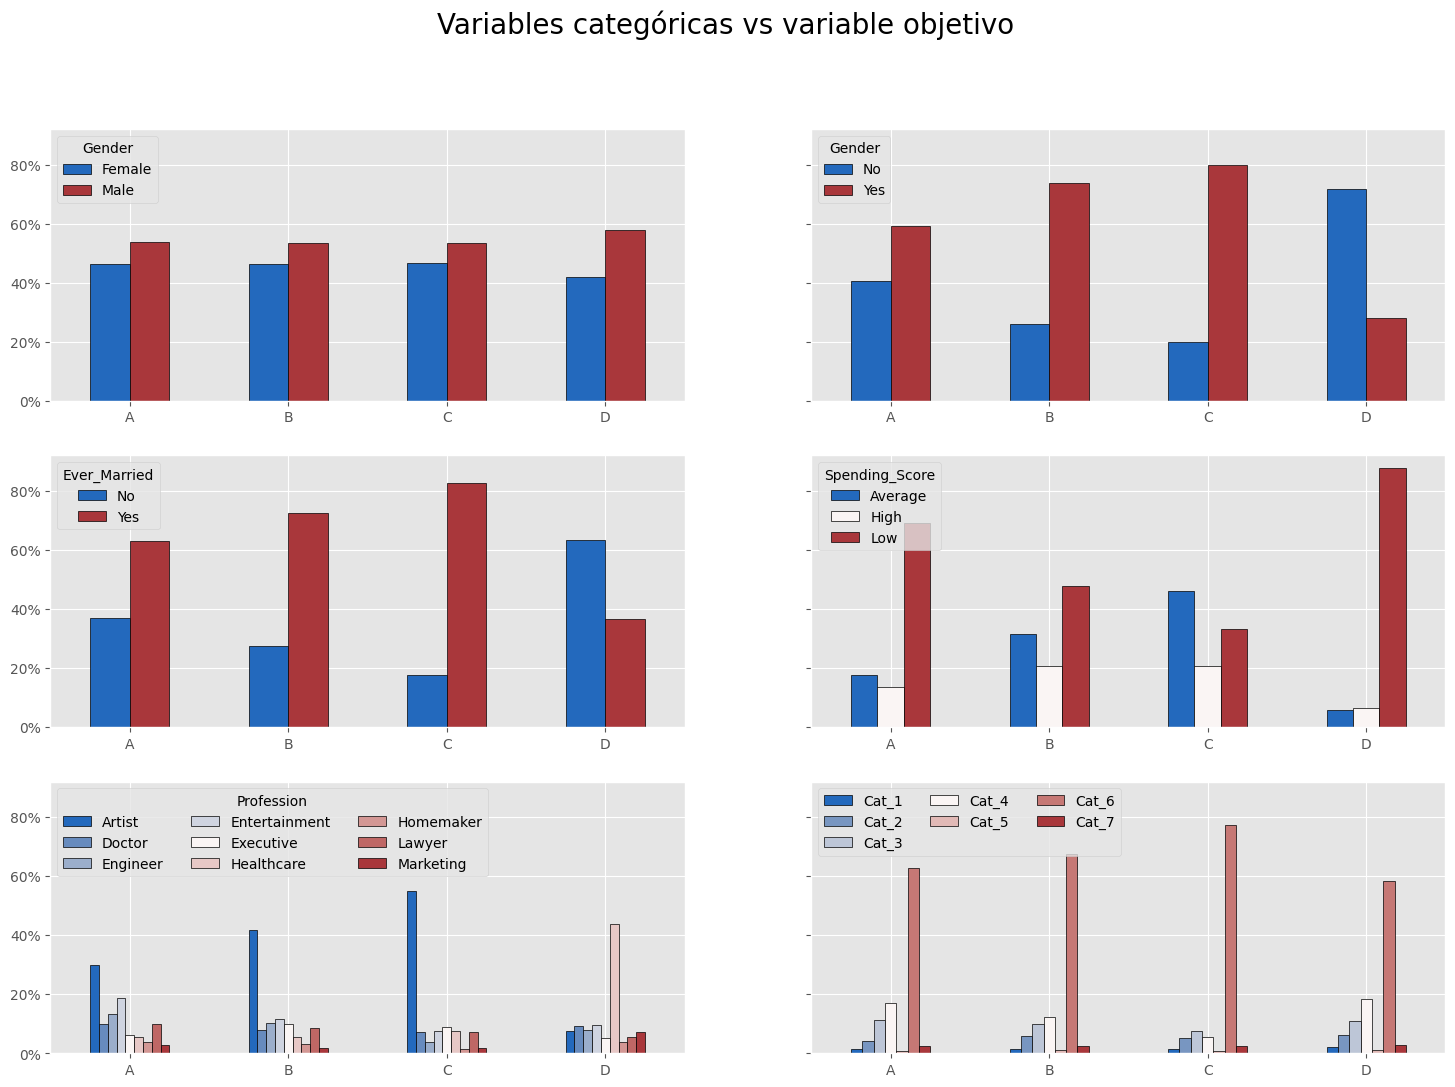

In [38]:
fig, ((ax1, ax2),
      (ax3, ax4),
      (ax5, ax6)) = plt.subplots(3,2, figsize = (18,12), sharey = True)
pd.crosstab(train.Segmentation,train.Gender,train.Age,aggfunc='count', normalize = 'index').plot(kind = 'bar', ax = ax1, edgecolor = 'black',colormap= 'vlag')
ax1.get_yaxis().set_major_formatter(matplotlib.ticker.PercentFormatter(xmax = 1,decimals = 0))  ## MUESTRA LOS TICKS DEL EJE Y EN PORCENTAJE
ax1.tick_params(axis='x', rotation=0)  ## ROTAR LAS ETIQUETAS DEL EJE X
ax1.legend(loc = 'upper left', title = 'Gender')
ax1.set_xlabel(None)

pd.crosstab(train.Segmentation,train.Ever_Married,train.Age,aggfunc='count', normalize = 'index').plot(kind = 'bar', ax = ax2, edgecolor = 'black', colormap= 'vlag')
ax2.get_yaxis().set_major_formatter(matplotlib.ticker.PercentFormatter(xmax = 1,decimals = 0))  ## MUESTRA LOS TICKS DEL EJE Y EN PORCENTAJE
ax2.tick_params(axis='x', rotation=0) 
ax2.legend(loc = 'upper left',  title = 'Gender')
ax2.set_xlabel(None)

pd.crosstab(train.Segmentation,train.Graduated,train.Age,aggfunc='count', normalize = 'index').plot(kind = 'bar', ax = ax3, edgecolor = 'black',colormap= 'vlag')
ax3.get_yaxis().set_major_formatter(matplotlib.ticker.PercentFormatter(xmax = 1,decimals = 0))  ## MUESTRA LOS TICKS DEL EJE Y EN PORCENTAJE
ax3.tick_params(axis='x', rotation=0)  ## ROTAR LAS ETIQUETAS DEL EJE X
ax3.legend(loc = 'upper left', title = 'Ever_Married')
ax3.set_xlabel(None)

pd.crosstab(train.Segmentation,train.Spending_Score,train.Age,aggfunc='count', normalize = 'index').plot(kind = 'bar', ax = ax4, edgecolor = 'black',colormap= 'vlag')
ax4.get_yaxis().set_major_formatter(matplotlib.ticker.PercentFormatter(xmax = 1,decimals = 0))  ## MUESTRA LOS TICKS DEL EJE Y EN PORCENTAJE
ax4.tick_params(axis='x', rotation = 0) 
ax4.legend(loc = 'upper left', title = 'Spending_Score')
ax4.set_xlabel(None)

pd.crosstab(train.Segmentation,train.Profession,train.Age,aggfunc='count', normalize = 'index').plot(kind = 'bar', ax = ax5, edgecolor = 'black',colormap= 'vlag')
ax5.get_yaxis().set_major_formatter(matplotlib.ticker.PercentFormatter(xmax = 1,decimals = 0))  ## MUESTRA LOS TICKS DEL EJE Y EN PORCENTAJE
ax5.tick_params(axis='x', rotation=0)  ## ROTAR LAS ETIQUETAS DEL EJE X
ax5.legend(loc = 'upper left', ncols = 3, title = 'Profession')
ax5.set_xlabel(None)

pd.crosstab(train.Segmentation,train.Var_1,train.Age,aggfunc='count', normalize = 'index').plot(kind = 'bar', ax = ax6, edgecolor = 'black',colormap= 'vlag')
ax6.get_yaxis().set_major_formatter(matplotlib.ticker.PercentFormatter(xmax = 1,decimals = 0))  ## MUESTRA LOS TICKS DEL EJE Y EN PORCENTAJE
ax6.tick_params(axis='x', rotation=0) 
ax6.legend(loc = 'upper left', ncols = 3)
ax6.set_xlabel(None)
fig.suptitle('Variables categóricas vs variable objetivo', fontsize = 20)
plt.show()

In [35]:
def calcular_coeficiente_contingencia(df: pd.DataFrame, cols: list, target_col: str) -> pd.DataFrame:
    resultados = []
    for col in cols:
        tabla_contingencia = pd.crosstab(df[col], df[target_col])
        chi2, p, dof, expected = chi2_contingency(tabla_contingencia)
        n = tabla_contingencia.values.sum()
        coef_contingencia = np.sqrt(chi2 / (n * min(len(tabla_contingencia.index) - 1, len(tabla_contingencia.columns) - 1)))
        resultados.append([col, coef_contingencia])
    df_resultado = pd.DataFrame(resultados, columns=['Variable', 'Coeficiente de Contingencia'])
    df_resultado.sort_values(by='Coeficiente de Contingencia', ascending=False, inplace=True)
    df_resultado.reset_index(drop=True, inplace=True)
    return df_resultado.round(4)

**Interpretación asociación entre variables categóricas independientes y variabel objetivo**
 - Todas las variables tienen un coeficiente menor a 0.6, por lo que ninguna presenta una asociación relativamente intensa con la variable objetivo. Sin embargo, la variable Ever_Married es la que mayor coeficiente de asociación tiene.


In [36]:
calcular_coeficiente_contingencia(train1,categ_idx, 'Segmentation')

,Variable,Coeficiente de Contingencia
0,Ever_Married,0.4275
1,Graduated,0.3711
2,Profession,0.3387
3,Spending_Score,0.3175
4,Var_1,0.1015
5,Gender,0.0460


### c. Extracción de información de los datos

### d. Comprensión y limpieza de datos


In [ ]:
##  //TODO ...SE DEBERÍAN ELIMINAR LOS OUTLIERS  ??

### e. Entrenar el modelo de clasificación

In [51]:
## HoldOut
X_train, X_test, y_train, y_test = train_test_split(train[num_idx + categ_idx], train[target_idx], test_size = 0.2, random_state = 123)

**Pipelines modelos**

In [56]:
## Parámetros para el GridSearchCV
grid_params = { 'model__max_depth': [1,4,8,12],
                'model__max_features': ['sqrt'],
                'model__max_leaf_nodes': [2,4,6,8],
                'model__min_samples_leaf': [5,10,20],
                'model__min_samples_split': [2, 5, 10],
                'model__n_estimators': [100,200]}

In [ ]:
## Reutilizamos los pipelines creados en el apartado de imputación, a excepción que aquí si se va a realizar una mejora en los hiperparámetros de los modelos.
rf_gs = GridSearchCV(clone(pl_dict.get('RandomForest')), grid_params, n_jobs = -4, cv = 5, scoring = 'accuracy')
rf_gs.fit(X_train, y_train)

In [59]:
print("Best Score of train set: " + str(rf_gs.best_score_))
print("Best parameter set: " + str(rf_gs.best_params_))
print("Test Score: " + str(rf_gs.score(X_test,y_test)))

Best Score of train set: 0.5060868316380371
Best parameter set: {'model__max_depth': 8, 'model__max_features': 'sqrt', 'model__max_leaf_nodes': 8, 'model__min_samples_leaf': 5, 'model__min_samples_split': 2, 'model__n_estimators': 100}
Test Score: 0.4936788874841972


In [ ]:
confusion_matrix(y_train,rf_gs.predict(X_train))

array([[ 621,  184,  315,  417],
       [ 380,  257,  601,  209],
       [ 190,  118, 1032,  229],
       [ 305,   83,   64, 1322]])

In [ ]:
confusion_matrix(y_test,rf_gs.predict(X_test))

array([[153,  46,  68, 132],
       [104,  56, 165,  56],
       [ 36,  32, 245,  64],
       [ 60,  21,  17, 327]])

## Reducción dimensionalidad

## Caracterización de los clientes por segmento